<a href="https://colab.research.google.com/github/w95wayne10/computer_vision/blob/master/summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mask import J, K, octogonal_kernel, N, LoG_mtx, DoG_mtx
from google.colab.patches import cv2_imshow

In [2]:
def Dilation(img, pattern):
  bo = (pattern.shape[0]-1)//2
  border_img = cv2.copyMakeBorder(img, bo, bo, bo, bo, cv2.BORDER_REPLICATE)
  m,n = img.shape
  result = np.zeros(img.shape)
  for i in range(5):
    for j in range(5):
      if pattern[i,j] == 1:
        result = np.maximum(result,border_img[i:i+m,j:j+n])
  return result

def Erosion(img, pattern):
  bo = (pattern.shape[0]-1)//2
  border_img = cv2.copyMakeBorder(img, bo, bo, bo, bo, cv2.BORDER_REPLICATE)
  m,n = img.shape
  result = np.ones(img.shape)*255
  for i in range(5):
    for j in range(5):
      if pattern[i,j] == 1:
        result = np.minimum(result,border_img[i:i+m,j:j+n])
  return result

def Opening(img, pattern):
  return Dilation(Erosion(img, pattern), pattern)

def Closing(img, pattern):
  return Erosion(Dilation(img, pattern), pattern)

In [3]:
# 讀檔
lena_gray = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)

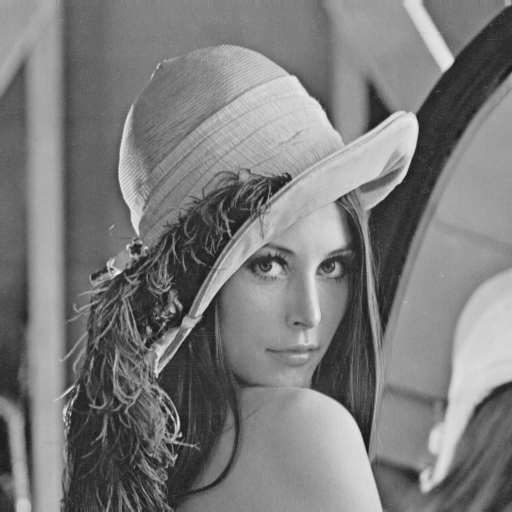

In [4]:
cv2_imshow(lena_gray)

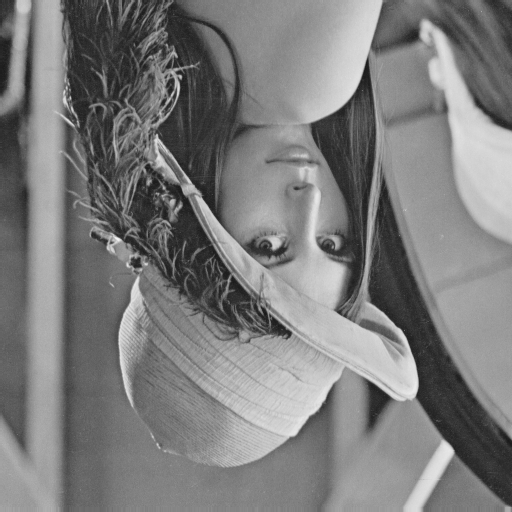

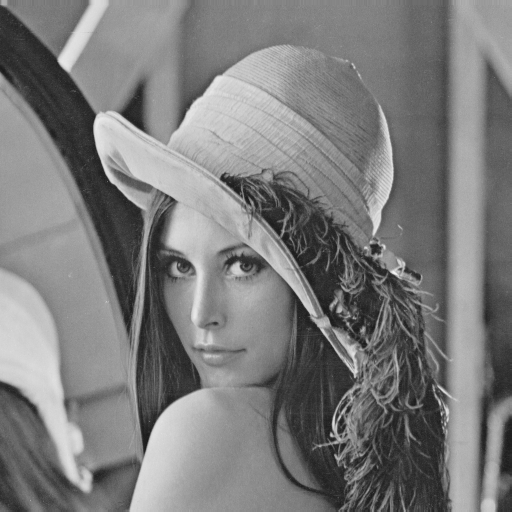

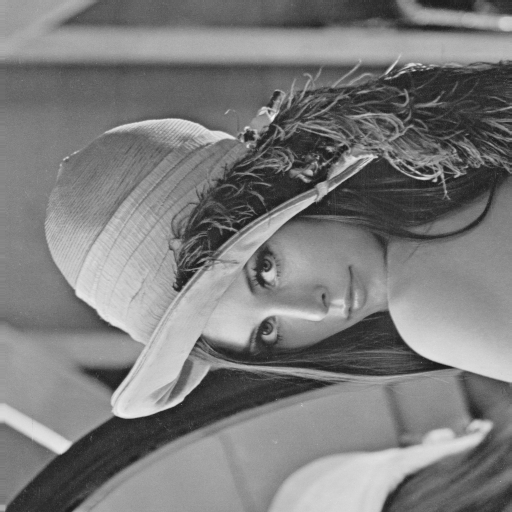

In [ ]:
# 變更順序達到旋轉鏡射等效果
upside_down_lena = lena_gray[::-1, :]
rightside_left_lena = lena_gray[:, ::-1]
diagonally_flip_lena = lena_gray.T

cv2_imshow(upside_down_lena)
cv2_imshow(rightside_left_lena)
cv2_imshow(diagonally_flip_lena)
#cv2.imwrite('upside_down_lena.bmp', upside_down_lena)
#cv2.imwrite('rightside_left_lena.bmp', rightside_left_lena)
#cv2.imwrite('diagonally_flip_lena.bmp', diagonally_flip_lena)

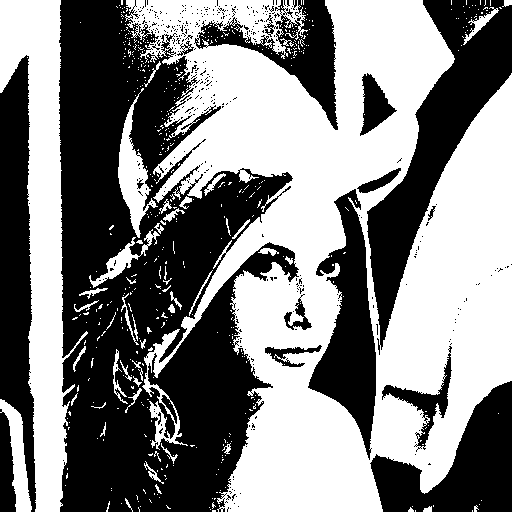

In [5]:
# 二元化
binarize_lena = lena_gray//128*255
cv2_imshow(binarize_lena)
#cv2.imwrite('binarize_lena.bmp', binarize_lena)

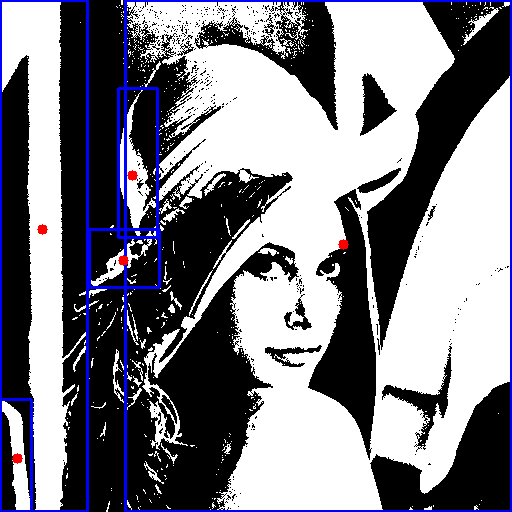

In [ ]:
# 分群
# 1. 分析
IDlist = []
IDlist.append(0)
IDtable = np.zeros((512,512),dtype=int)
ID = 1
for r, row in enumerate(binarize_lena):
  for c, pix in enumerate(row):
    if pix==0:
      continue
    if r:
      if c and IDtable[r-1,c-1]:
        IDtable[r,c] = IDtable[r-1,c-1]
      elif IDtable[r-1,c]:
        if IDtable[r,c]:
          IDlist[IDtable[r-1,c]]["neighbor"].add(IDtable[r,c])
          IDlist[IDtable[r,c]]["neighbor"].add(IDtable[r-1,c])
        else:
          IDtable[r,c] = IDtable[r-1,c]
      elif c<511 and IDtable[r-1,c+1]:
        if IDtable[r,c]:
          IDlist[IDtable[r-1,c+1]]["neighbor"].add(IDtable[r,c])
          IDlist[IDtable[r,c]]["neighbor"].add(IDtable[r-1,c+1])
        else:
          IDtable[r,c] = IDtable[r-1,c+1]
    if c and IDtable[r,c-1]:
      if IDtable[r,c]:
        IDlist[IDtable[r,c-1]]["neighbor"].add(IDtable[r,c])
        IDlist[IDtable[r,c]]["neighbor"].add(IDtable[r,c-1])
      else:
        IDtable[r,c] = IDtable[r,c-1]
    if not IDtable[r,c]:
      IDtable[r,c] = ID
      ID+=1
      IDlist.append({"up":512,"down":0,"left":512,"right":0,"count":0,"sum":[0,0],"neighbor":set()})
    IDlist[IDtable[r,c]]["up"] = min(IDlist[IDtable[r,c]]["up"],r)
    IDlist[IDtable[r,c]]["down"] = max(IDlist[IDtable[r,c]]["down"],r)
    IDlist[IDtable[r,c]]["left"] = min(IDlist[IDtable[r,c]]["left"],c)
    IDlist[IDtable[r,c]]["right"] = max(IDlist[IDtable[r,c]]["right"],c)
    IDlist[IDtable[r,c]]["count"] += 1
    IDlist[IDtable[r,c]]["sum"][0] += r
    IDlist[IDtable[r,c]]["sum"][1] += c
for i in range(len(IDlist)-1,1,-1):
  if not IDlist[i]['neighbor']:
    continue
  belong = min(IDlist[i]['neighbor'])
  if belong == i:
    continue
  for j in IDlist[i]['neighbor']:
    if i==j:
      continue
    IDlist[j]['neighbor'].add(belong)
    if i in IDlist[j]['neighbor']:
      IDlist[j]['neighbor'].remove(i)
  IDlist[belong]["up"] = min(IDlist[belong]["up"],IDlist[i]["up"])
  IDlist[belong]["down"] = max(IDlist[belong]["down"],IDlist[i]["down"])
  IDlist[belong]["left"] = min(IDlist[belong]["left"],IDlist[i]["left"])
  IDlist[belong]["right"] = max(IDlist[belong]["right"],IDlist[i]["right"])
  IDlist[belong]["count"] += IDlist[i]["count"]
  IDlist[belong]["sum"][0] += IDlist[i]["sum"][0]
  IDlist[belong]["sum"][1] += IDlist[i]["sum"][1]
  IDlist.pop(i)
for i in range(len(IDlist)-1,1,-1):
  if IDlist[i]["count"]<500:
    IDlist.pop(i)
# 2. 圖上標記
image = cv2.cvtColor(binarize_lena, cv2.COLOR_GRAY2BGR)
for grp in IDlist:
  if grp == 0:
    continue
  image = cv2.circle(image, 
          (int(np.round(grp["sum"][1]/grp["count"])), int(np.round(grp["sum"][0]/grp["count"]))), 
          radius=0, 
          color=(0, 0, 255), 
          thickness=10)
  image = cv2.rectangle(image, (grp["left"],grp["up"]), (grp["right"],grp["down"]), (255,0, 0), 2)
cv2_imshow(image)
# cv2.imwrite('group_of_lena.bmp', image)

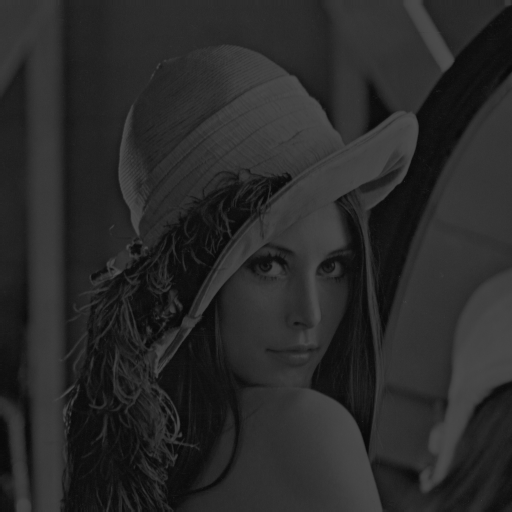

In [ ]:
divid_3_lena_gray = np.uint8(np.rint(lena_gray/3))

cv2_imshow(divid_3_lena_gray)
#cv2.imwrite('divid_3_lena_gray.bmp', divid_3_lena_gray)

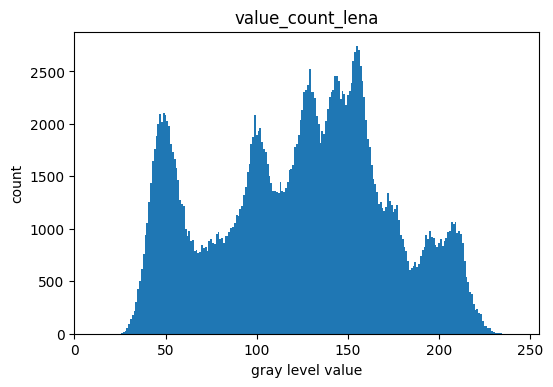

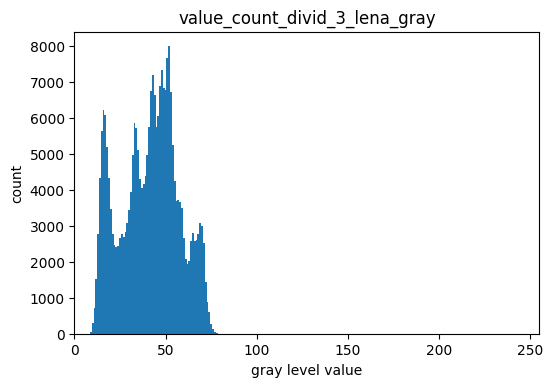

In [ ]:
# 灰階圖的色階統計

def gray_level_value_count(gray_img):
  value_count = [0]*256
  for row in gray_img:
    for pix in row:
      value_count[pix]+=1
  return value_count

def gray_level_value_count_chart(gray_img, out_fig_name):
  value_count = gray_level_value_count(gray_img)
  plt.figure(dpi=100)
  #plt.figure(dpi=500)
  plt.bar(list(range(256)),value_count,1)
  plt.title(out_fig_name[:-4])
  plt.xlabel("gray level value")
  plt.xlim(0,255)
  plt.ylabel("count")
  plt.show()
  #plt.savefig(out_fig_name)
  return

gray_level_value_count_chart(lena_gray, 'value_count_lena.png')
gray_level_value_count_chart(divid_3_lena_gray, 'value_count_divid_3_lena_gray.png')

In [ ]:
def gray_hist_equalization(gray_img):
  value_cumsum = []
  minlevel, maxlevel, sum_value = -1, -1, 0
  novalue = True
  value_count = gray_level_value_count(gray_img)
  for level, count in enumerate(value_count):
    sum_value += count
    value_cumsum.append(sum_value)
    if novalue and count>0:
      novalue=False
      minlevel = level
    if count>0:
      maxlevel = level

  new_value_count = [0]*256
  transfor_list = [0]*256
  Denominator = value_cumsum[maxlevel]-value_cumsum[minlevel]
  Numerator = lambda x: value_cumsum[x]-value_cumsum[minlevel]
  for level in range(minlevel, maxlevel+1):
    new_level = int(np.round(Numerator(level)*255/Denominator))
    transfor_list[level] = new_level
    new_value_count[new_level] += value_count[level]

  hist_equalization_lena_gray = gray_img.copy()
  for r,row in enumerate(hist_equalization_lena_gray):
    for c,_ in enumerate(row):
      hist_equalization_lena_gray[r,c] = transfor_list[hist_equalization_lena_gray[r,c]]
  return hist_equalization_lena_gray

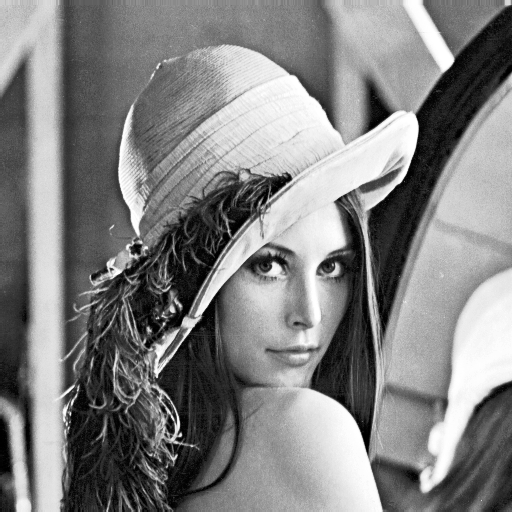

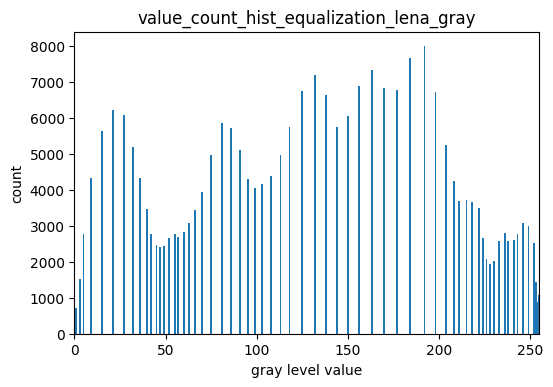

In [ ]:
hist_equalization_lena_gray = gray_hist_equalization(divid_3_lena_gray)
cv2_imshow(hist_equalization_lena_gray)
#cv2.imwrite('hist_equalization_lena_gray.bmp', hist_equalization_lena_gray)
gray_level_value_count_chart(hist_equalization_lena_gray, 'value_count_hist_equalization_lena_gray.png')

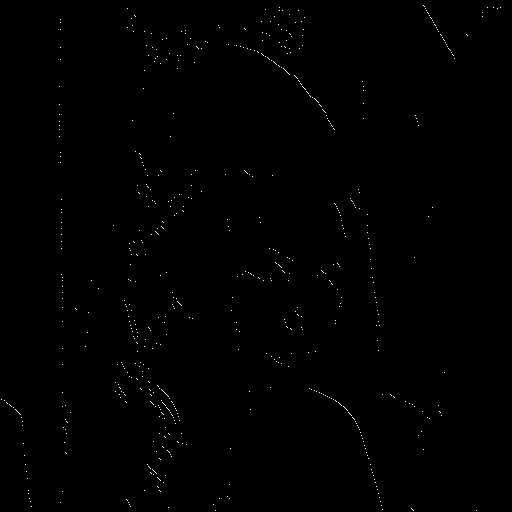

In [ ]:
JErosion = Erosion(binarize_lena, J)
KErosion = Erosion(255-binarize_lena, K)
HitandMiss_binarize_lena = ((JErosion > 128)&(KErosion > 128))*255

cv2_imshow(HitandMiss_binarize_lena)
#cv2.imwrite('HitandMiss_binarize_lena.bmp', HitandMiss_binarize_lena)

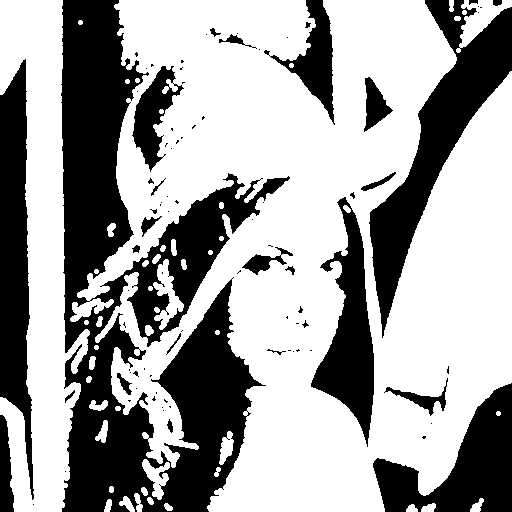

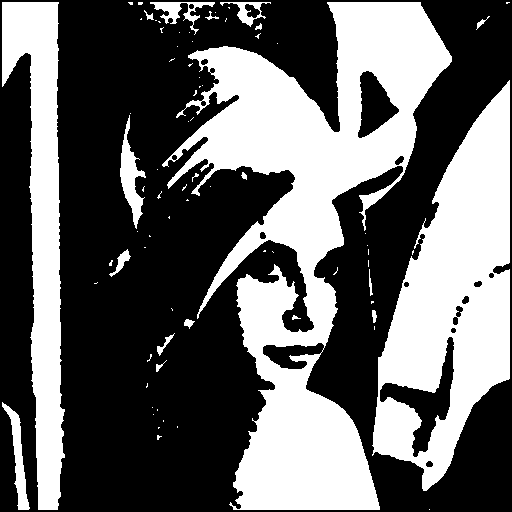

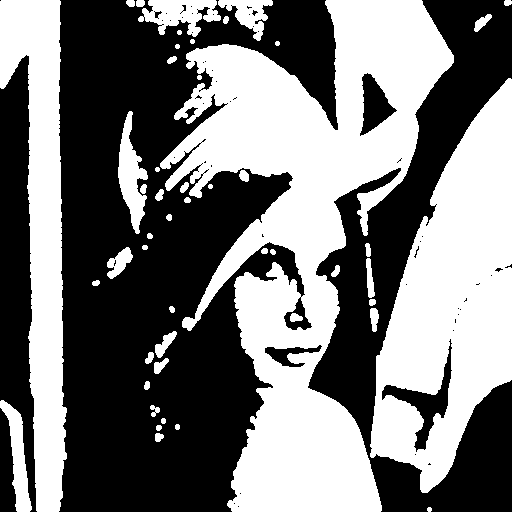

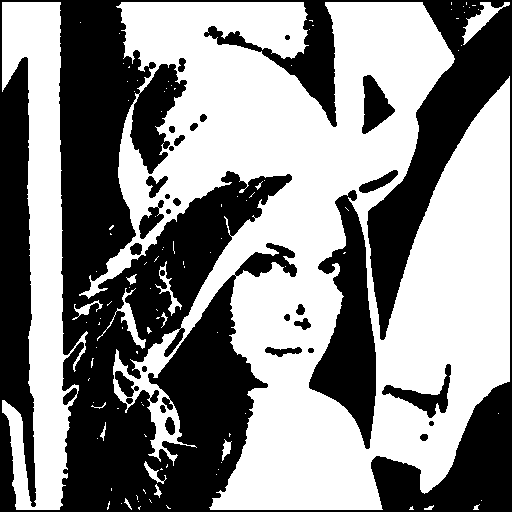

In [ ]:
Dilation_binarize_lena = Dilation(binarize_lena, octogonal_kernel)
Erosion_binarize_lena = Erosion(binarize_lena, octogonal_kernel)
Opening_binarize_lena = Dilation(Erosion_binarize_lena, octogonal_kernel)
Closing_binarize_lena = Erosion(Dilation_binarize_lena, octogonal_kernel)

cv2_imshow(Dilation_binarize_lena)
cv2_imshow(Erosion_binarize_lena)
cv2_imshow(Opening_binarize_lena)
cv2_imshow(Closing_binarize_lena)
#cv2.imwrite('Dilation_binarize_lena.bmp', Dilation_binarize_lena)
#cv2.imwrite('Erosion_binarize_lena.bmp', Erosion_binarize_lena)
#cv2.imwrite('Opening_binarize_lena.bmp', Opening_binarize_lena)
#cv2.imwrite('Closing_binarize_lena.bmp', Closing_binarize_lena)

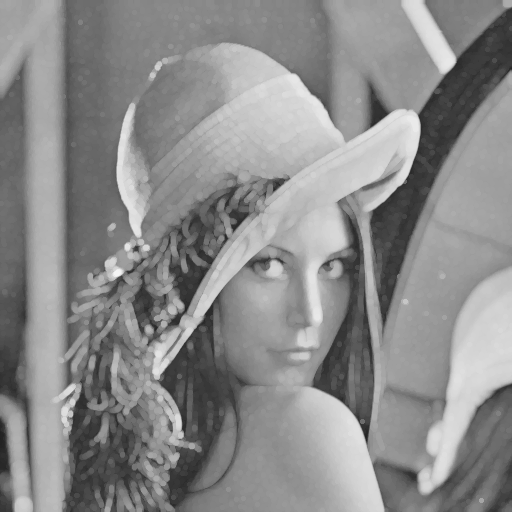

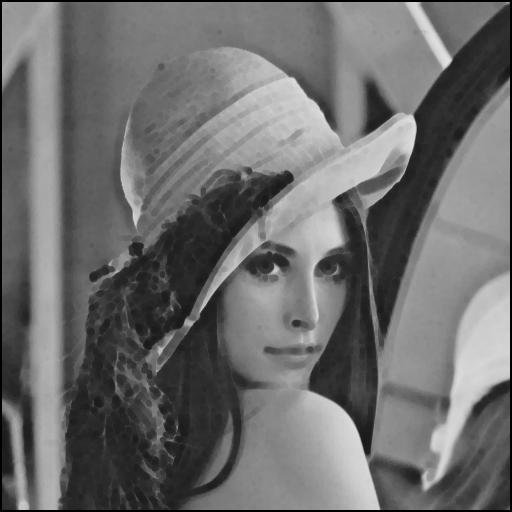

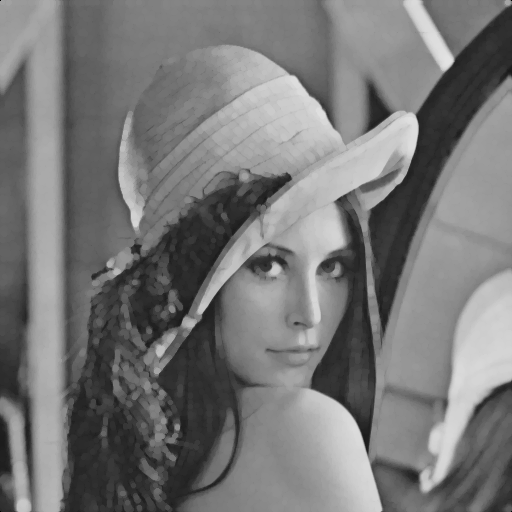

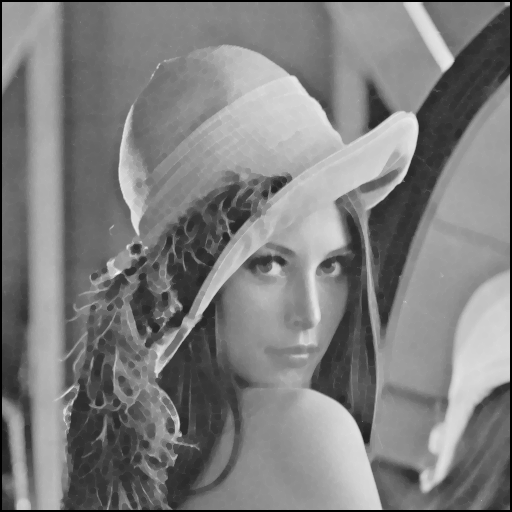

In [ ]:
Dilation_lena = Dilation(lena_gray, octogonal_kernel)
Erosion_lena = Erosion(lena_gray, octogonal_kernel)
Opening_lena = Dilation(Erosion_lena, octogonal_kernel)
Closing_lena = Erosion(Dilation_lena, octogonal_kernel)


cv2_imshow(Dilation_lena)
cv2_imshow(Erosion_lena)
cv2_imshow(Opening_lena)
cv2_imshow(Closing_lena)
#cv2.imwrite('Dilation_lena.bmp', Dilation_lena)
#cv2.imwrite('Erosion_lena.bmp', Erosion_lena)
#cv2.imwrite('Opening_lena.bmp', Opening_lena)
#cv2.imwrite('Closing_lena.bmp', Closing_lena)

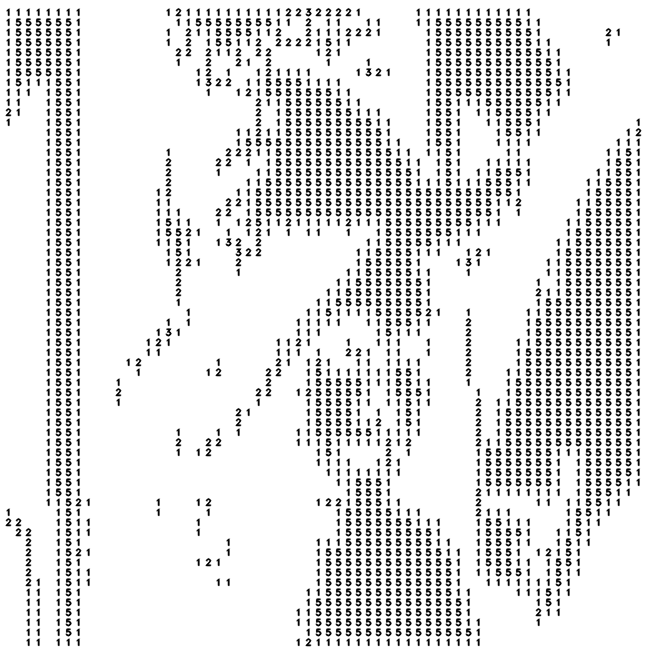

In [ ]:
binarize64_lena = np.zeros((64,64))
for r in range(64):
  for c in range(64):
    binarize64_lena[r,c] = binarize_lena[r*8,c*8]
check_table = np.zeros((66,66))
check_table[1:-1,1:-1] = binarize64_lena

def h(b,c,d,e):
  if b != c:
    return 's'
  else:
    if d==b and e==b:
      return 'r'
    else:
      return 'q'

def f(mtx):
  mtx_list = mtx.reshape(-1)
  qvalue = 0
  rvalue = 0
  for ads in [[4,5,2,1],[4,1,0,3],[4,3,6,7],[4,7,8,5]]:
    state = h(*mtx_list[ads])
    qvalue += 1 if state=='q' else 0
    rvalue += 1 if state=='r' else 0
  if rvalue==4:
    return 5
  else:
    return qvalue

img = np.zeros((650, 650, 3), np.uint8)
img.fill(255)
result = np.zeros((64,64))
for r in range(64):
  for c in range(64):
    if check_table[r+1,c+1]>254:
      result[r,c] = f(check_table[r:r+3,c:c+3])
      if int(np.around(result[r,c]))>0:
        cv2.putText(img, str(int(np.around(result[r,c]))), (c*10+5,r*10+15), cv2.FONT_HERSHEY_DUPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

cv2_imshow(img)
# cv2.imwrite('img.bmp', img)

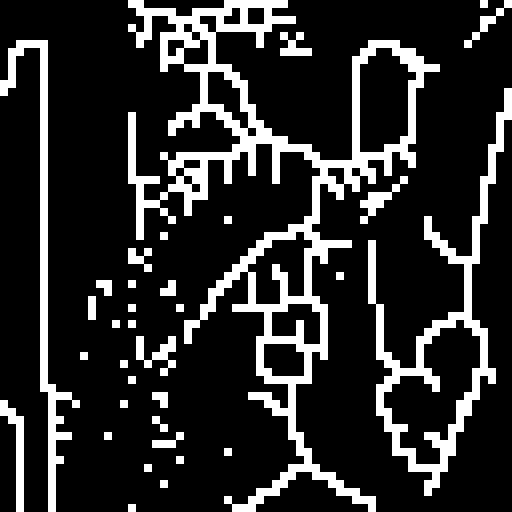

In [ ]:
binarize64_lena = np.zeros((64,64))
for r in range(64):
  for c in range(64):
    binarize64_lena[r,c] = binarize_lena[r*8,c*8]

def y(mtx):
  mtx_list = mtx.reshape(-1)
  if mtx_list[4] == 1:
    if 1 in mtx_list[[1,3,5,7]]:
      return 'p'
  return 'q'

def f2(mtx):
  mtx_list = mtx.reshape(-1)
  qvalue = 0
  rvalue = 0
  for ads in [[4,5,2,1],[4,1,0,3],[4,3,6,7],[4,7,8,5]]:
    state = h(*mtx_list[ads])
    qvalue += 1 if state=='q' else 0
  if qvalue==1:
    return 0
  else:
    return 255

def thinning_one_step(org_lena):
  check_table = np.zeros((66,66))
  check_table[1:-1,1:-1] = org_lena
  result = np.zeros((64,64))
  for r in range(64):
    for c in range(64):
      if check_table[r+1,c+1]>254:
        result[r,c] = int(np.around(f(check_table[r:r+3,c:c+3])))
  check_table2 = np.zeros((66,66))
  check_table2[1:-1,1:-1] = result
  result2 = np.zeros((64,64),str)
  for r in range(64):
    for c in range(64):
      if check_table2[r+1,c+1]>0.5:
        result2[r,c] = y(check_table2[r:r+3,c:c+3])
  new_lena = check_table[1:-1,1:-1]
  for r in range(64):
    for c in range(64):
      if result2[r,c]=='p':
        new_lena[r,c] = f2(check_table[r:r+3,c:c+3])
  return new_lena

org_lena = binarize64_lena
new_lena = thinning_one_step(org_lena)
#cv2_imshow(cv2.resize(new_lena, (512,512), interpolation = cv2.INTER_AREA))
while not np.array_equal(org_lena, new_lena):
  org_lena = new_lena
  new_lena = thinning_one_step(org_lena)
  #cv2_imshow(cv2.resize(new_lena, (512,512), interpolation = cv2.INTER_AREA))

#cv2_imshow(new_lena)
cv2_imshow(cv2.resize(new_lena, (512,512), interpolation = cv2.INTER_AREA))
#cv2.imwrite('new_lena.bmp', new_lena)

Gnoise10, SNR=-7.990318123597495


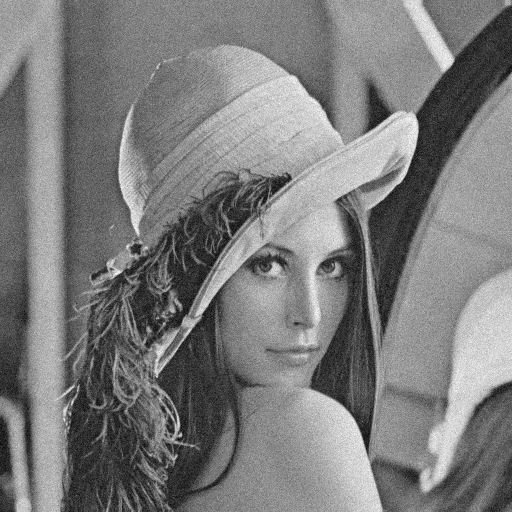

Gnoise30, SNR=-6.884867466657565


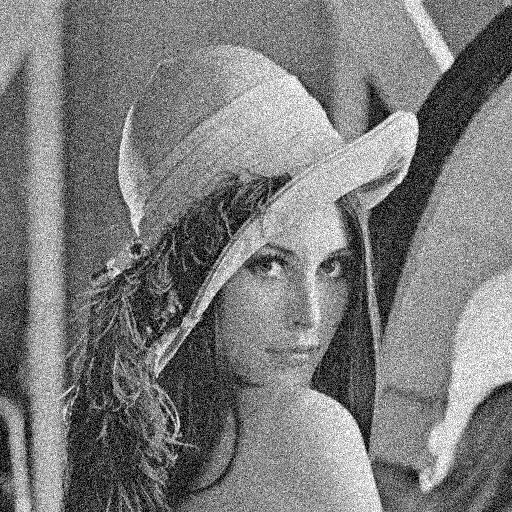

SPnoise005, SNR=1.1049569857035522


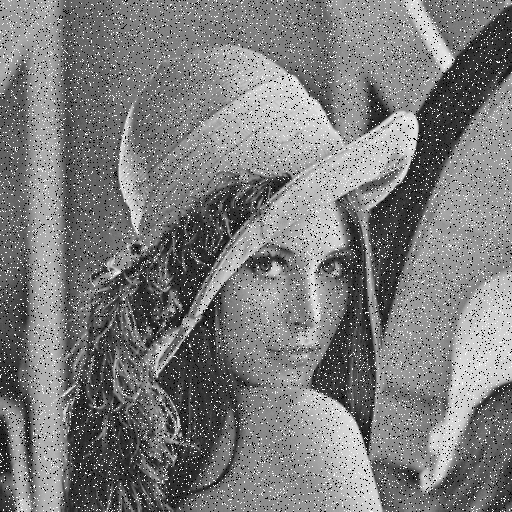

SPnoise010, SNR=-1.482917146975663


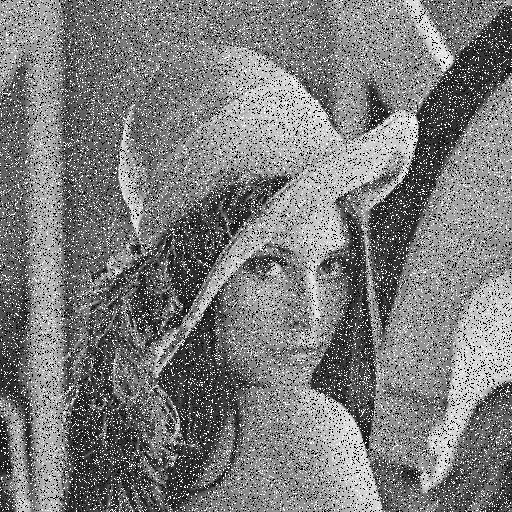

Gnoise10_Box3x3, SNR=17.731328891146795


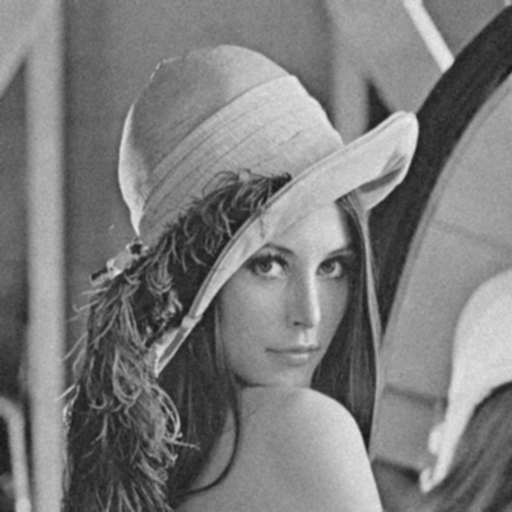

Gnoise10_Box5x5, SNR=14.857531171766096


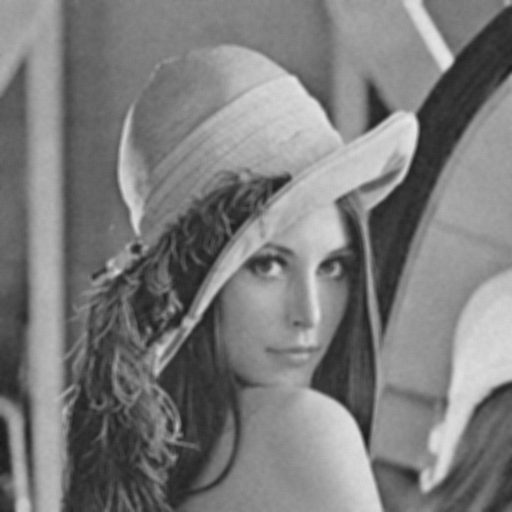

Gnoise10_Median3x3, SNR=17.663887677107514


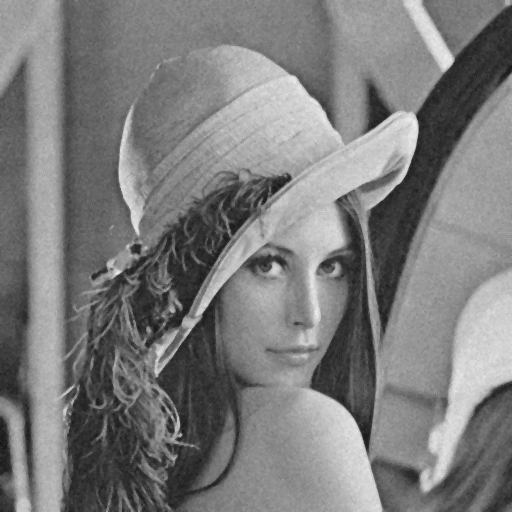

Gnoise10_Median5x5, SNR=15.982800087481753


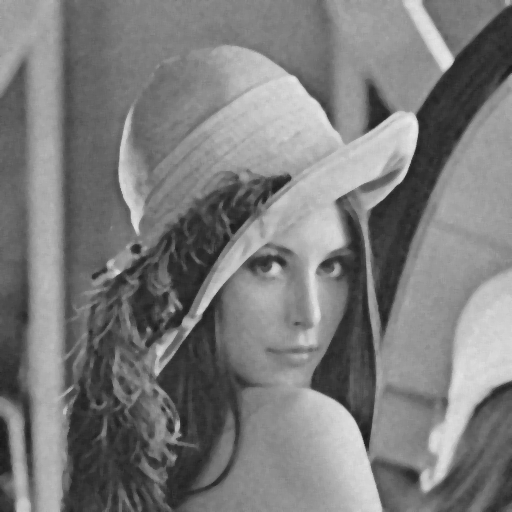

Gnoise10_OthenC, SNR=13.230951398352273


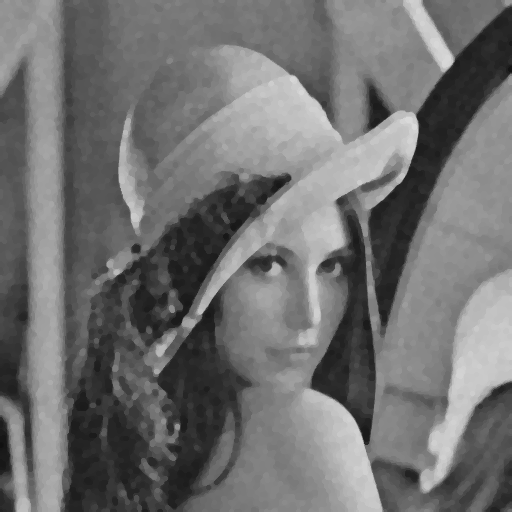

Gnoise10_CthenO, SNR=13.568396786437793


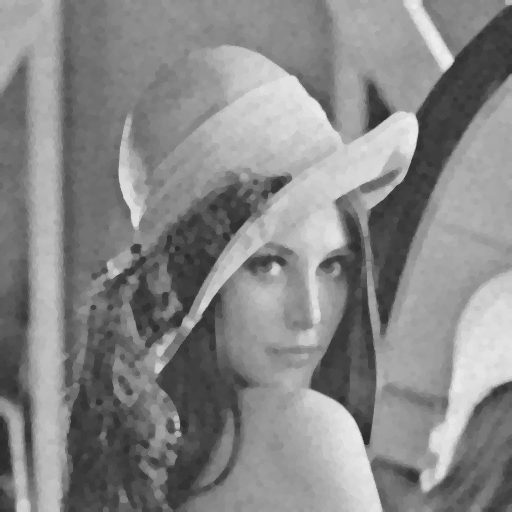

Gnoise30_Box3x3, SNR=12.572069618404335


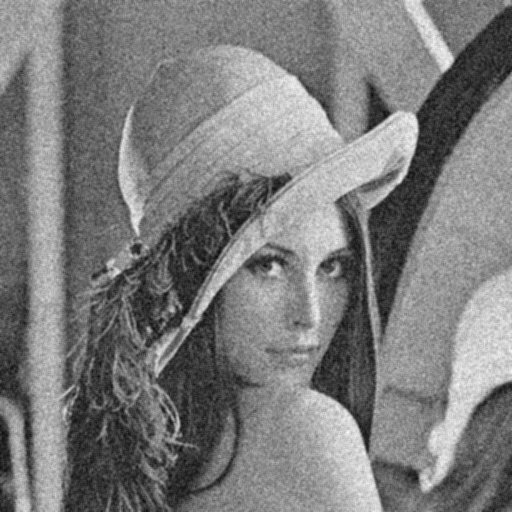

Gnoise30_Box5x5, SNR=13.283025927607572


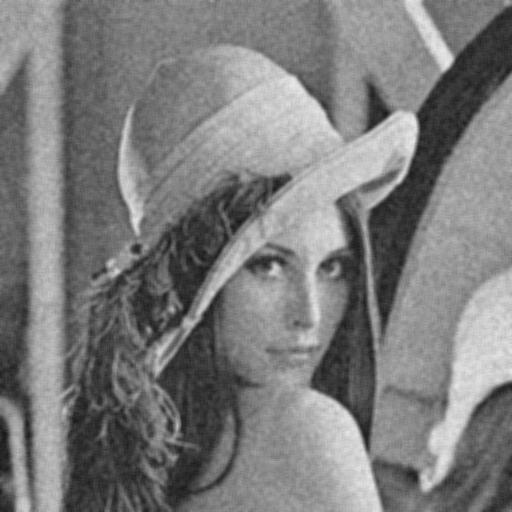

Gnoise30_Median3x3, SNR=11.08222094926611


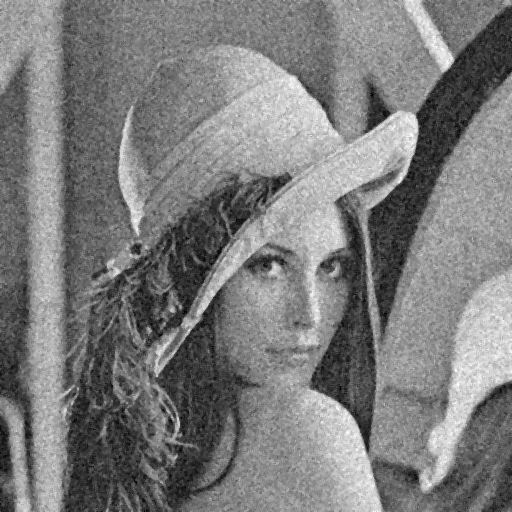

Gnoise30_Median5x5, SNR=12.877634401286048


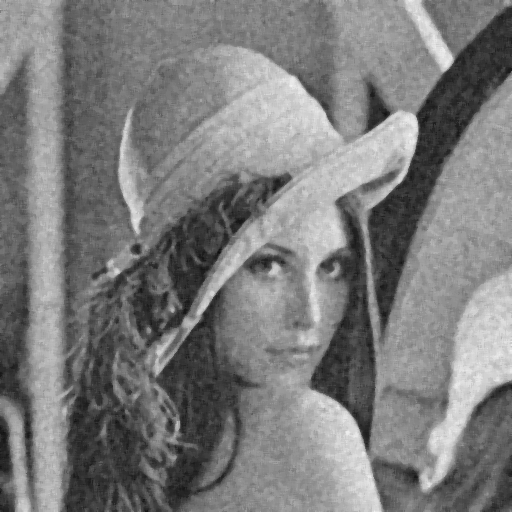

Gnoise30_OthenC, SNR=11.178303369548084


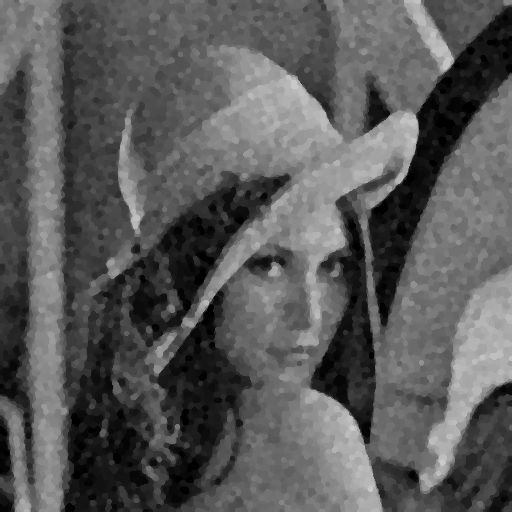

Gnoise30_CthenO, SNR=11.199056700121798


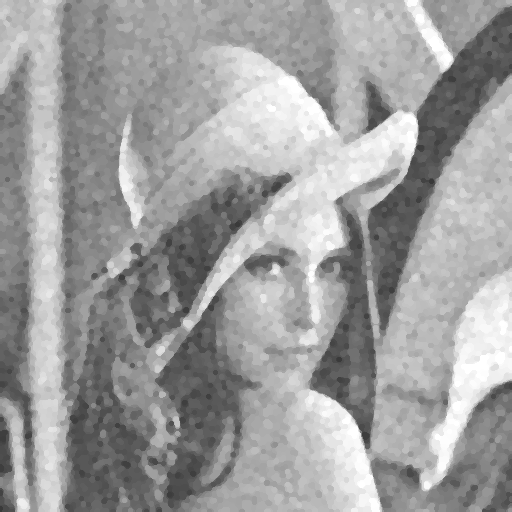

SPnoise005_Box3x3, SNR=9.476590567191986


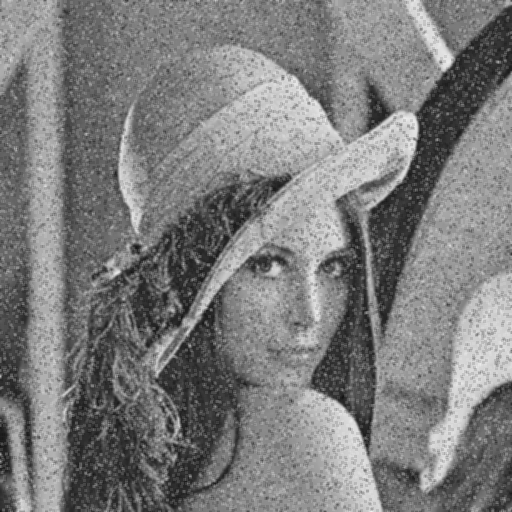

SPnoise005_Box5x5, SNR=11.15829778771715


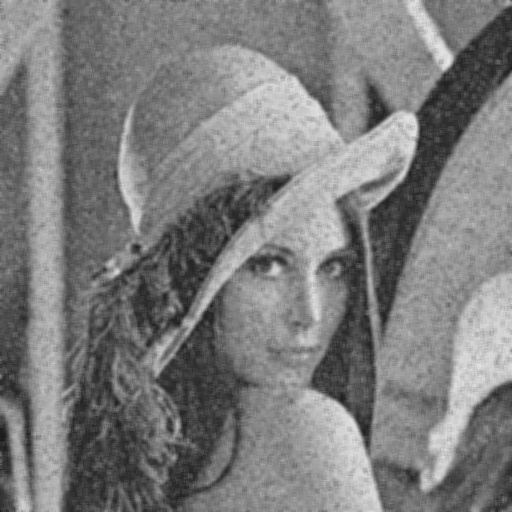

SPnoise005_Median3x3, SNR=19.037509254083677


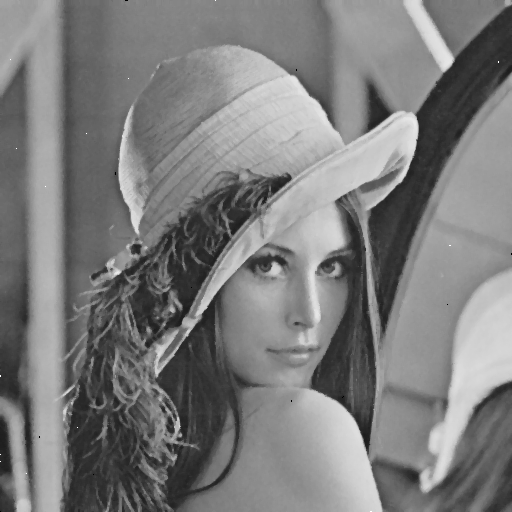

SPnoise005_Median5x5, SNR=16.378268209781645


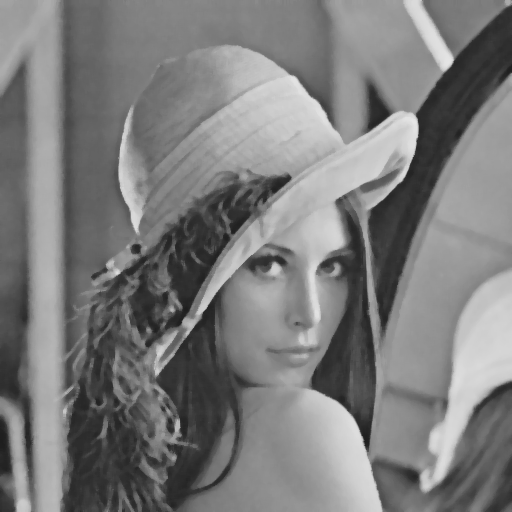

SPnoise005_OthenC, SNR=5.9226307015043425


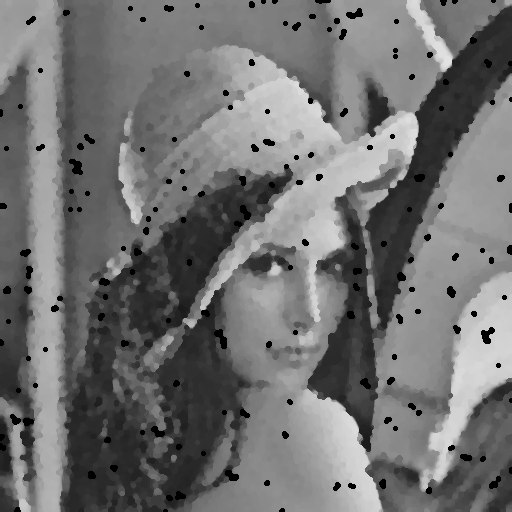

SPnoise005_CthenO, SNR=5.319054185724741


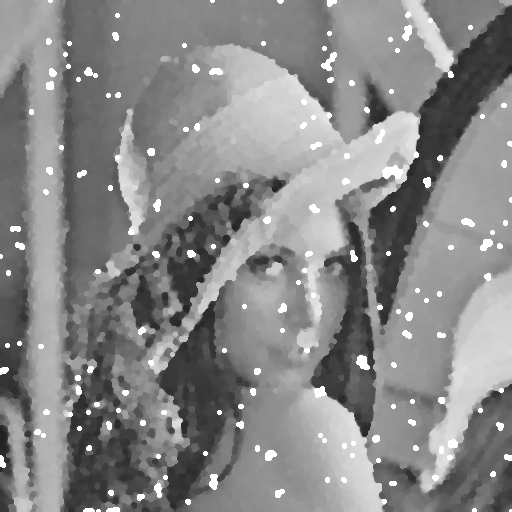

SPnoise010_Box3x3, SNR=6.372894568128303


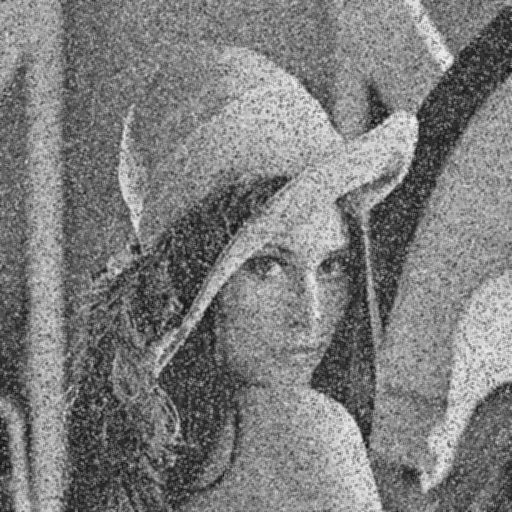

SPnoise010_Box5x5, SNR=8.562899297949526


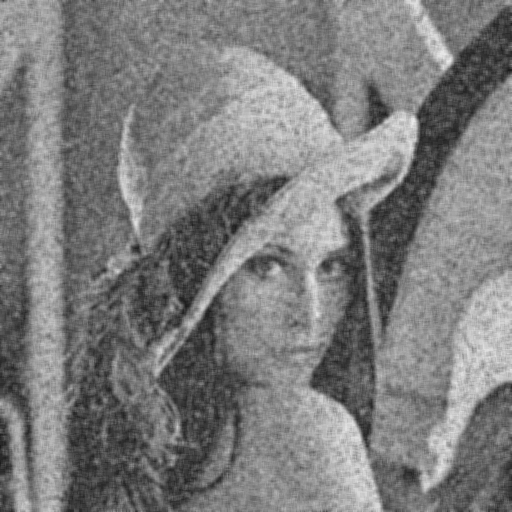

SPnoise010_Median3x3, SNR=15.184534342429126


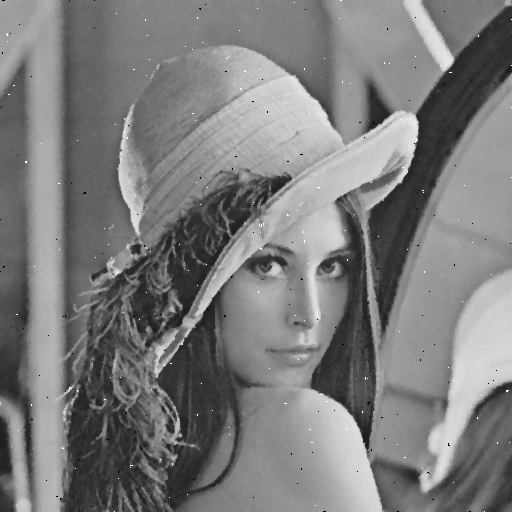

SPnoise010_Median5x5, SNR=15.751519997161573


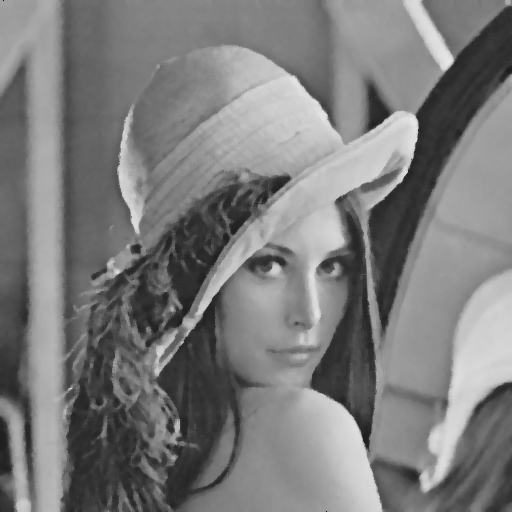

SPnoise010_OthenC, SNR=-2.1363278297921386


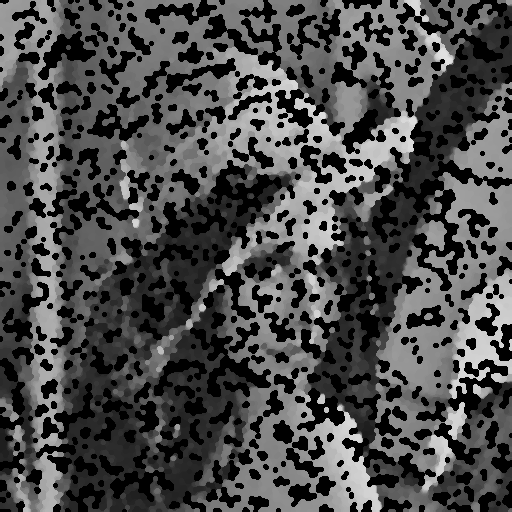

SPnoise010_CthenO, SNR=-2.5735689615730446


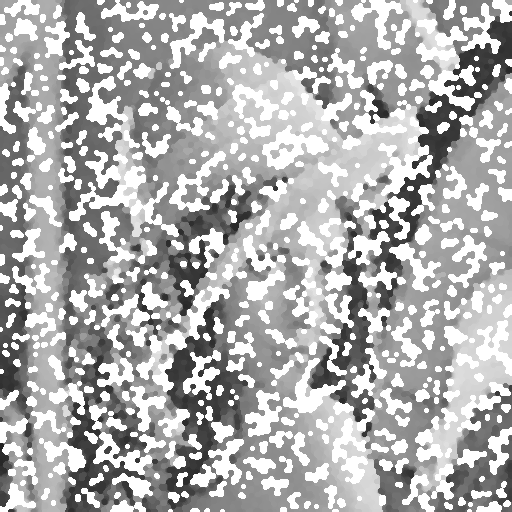

In [7]:
def BoxFilter(img, size):
  bo = 1 if size == 3 else 2
  border_img = cv2.copyMakeBorder(img,bo,bo,bo,bo,cv2.BORDER_REPLICATE)
  m,n = lena_gray.shape
  total = np.zeros((m,n))
  for r in range(size):
    for c in range(size):
      total += border_img[r:r+m,c:c+n]
  result = total/(size**2)
  return np.around(result)

def MedianFilter(img, size):
  bo = 1 if size == 3 else 2
  border_img = cv2.copyMakeBorder(img,bo,bo,bo,bo,cv2.BORDER_REPLICATE)
  m,n = lena_gray.shape
  total = np.zeros((m,n,size**2))
  i = 0
  for r in range(size):
    for c in range(size):
      total[:,:,i] = border_img[r:r+m,c:c+n]
      i+=1
  total_sort = np.sort(total,2)
  result = total_sort[:,:,size**2//2]
  return result

N = lena_gray.shape[0]*lena_gray.shape[1]
mu_s = np.sum(lena_gray)/N
VS = np.sum((lena_gray-mu_s)**2)/N

noise_img_dict = {}
for method in ["g", "sp"]:
  for level in range(2):
    if method == "g":
      amplitude = 10 if level==0 else 30
      noise = amplitude * np.random.normal(0,1,lena_gray.shape)
      noise_img = np.around(lena_gray + noise)
      noise_img[noise_img>255] = 255
      noise_img[noise_img<0] = 0
      noise_img_dict["Gnoise"+str(amplitude)] = np.uint8(noise_img)
    else:
      prob = 0.05 if level==0 else 0.1
      noise_value = np.random.uniform(0,1,lena_gray.shape)
      noise_img = lena_gray.copy()
      noise_img[noise_value>=(1-prob)] = 255
      noise_img[noise_value<=prob] = 0
      noise_img_dict["SPnoise"+str(prob).replace(".", "")+("0" if level==1 else "")] = noise_img

for NIname, img in noise_img_dict.items():
  mu_n = np.sum(img-lena_gray)/N
  VN = np.sum((img-lena_gray-mu_n)**2)/N
  SNR = 20*np.log10(np.sqrt(VS)/np.sqrt(VN))
  print(NIname+", SNR="+str(SNR))
  cv2_imshow(img)
  #cv2.imwrite(NIname+".bmp", img)

for NIname, img in noise_img_dict.items():
  for method in ["Box", "Median", "OandC"]:
    for case in range(2):
      if method in ["Box", "Median"]:
        size = 3 if case == 0 else 5
        result = BoxFilter(img, size) if method=="Box" else MedianFilter(img, size)
        Rname = NIname+"_"+method+str(size)+"x"+str(size)
      else:
        methodName = "OthenC" if case==0 else "CthenO"
        result = Closing(Opening(img, octogonal_kernel), octogonal_kernel) if case==0 else Opening(Closing(img, octogonal_kernel), octogonal_kernel)
        Rname = NIname+"_"+methodName
      mu_n = np.sum(result-lena_gray)/N
      VN = np.sum((result-lena_gray-mu_n)**2)/N
      SNR = 20*np.log10(np.sqrt(VS)/np.sqrt(VN))
      print(Rname+", SNR="+str(SNR))
      cv2_imshow(result)
      #cv2.imwrite(Rname+".bmp",result)

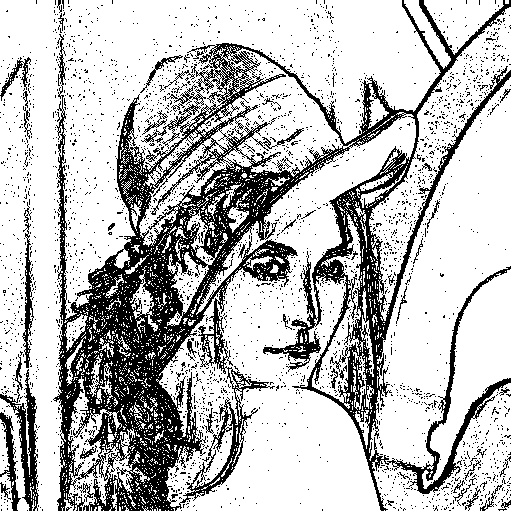

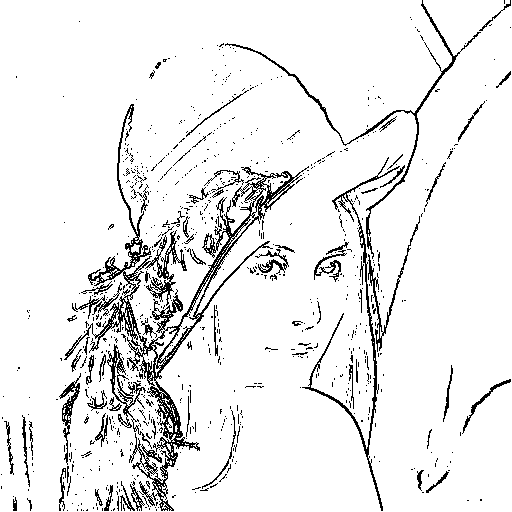

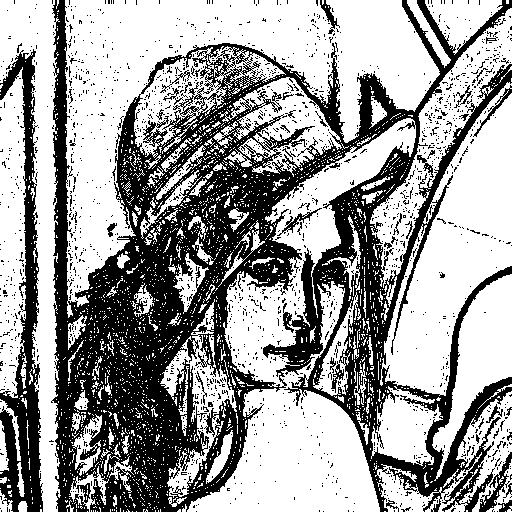

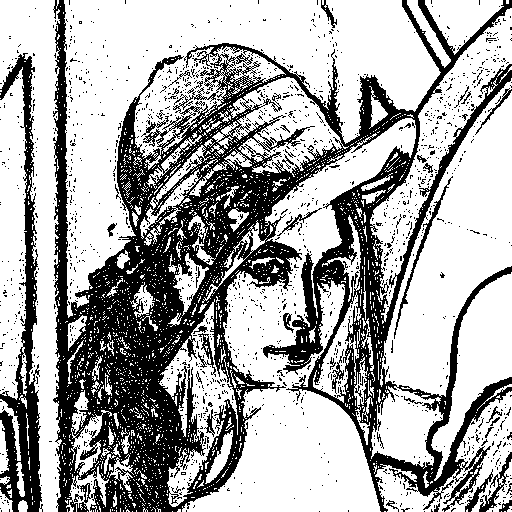

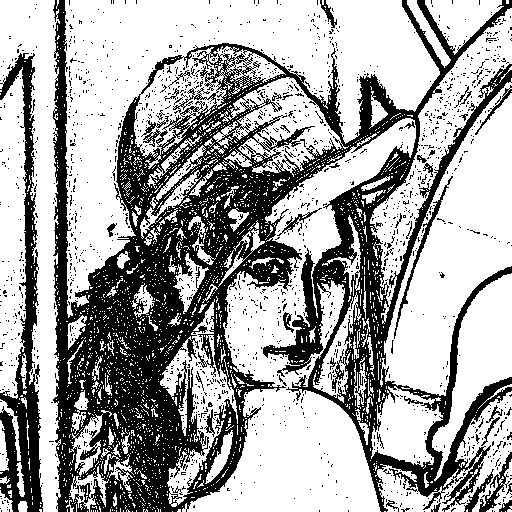

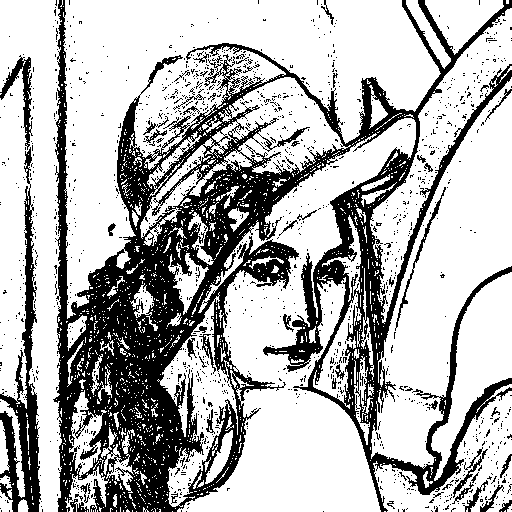

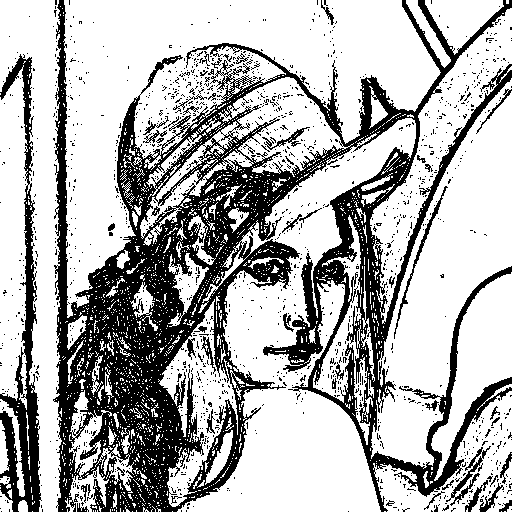

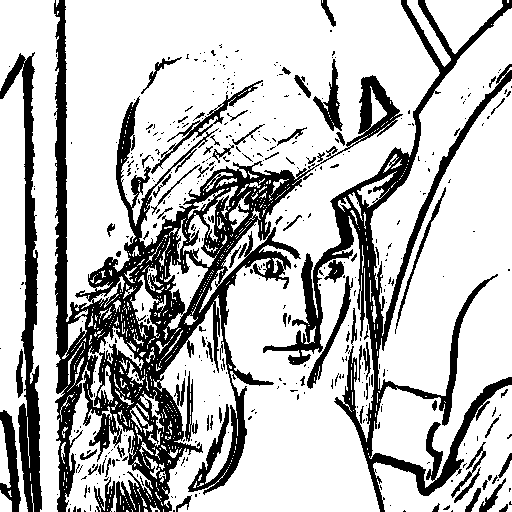

In [8]:
def conv(img_org, patn):
  img = img_org.astype(float)
  m,n = patn.shape
  M,N = img.shape
  result = np.zeros((M-m+1,N-n+1))
  for r in range(m):
    for c in range(n):
      result += img[r:r+M-m+1,c:c+N-n+1] * patn[r,c]
  return result 

def spin(mtx):
  a,b,c = [0,0,1],[1,2,2],[0,1,2]
  return np.array([mtx[a,b],mtx[c,c],mtx[b,a]])

def Robert_Operator(img, threshold):
  m,n = img.shape
  magnitude = np.zeros((m,n))
  temp = img.astype(float)
  magnitude[0:m-1,0:n-1] = np.sqrt((temp[1:m,1:n]-temp[0:m-1,0:n-1])**2 + (temp[1:m,0:n-1]-temp[0:m-1,1:n])**2)
  return np.uint8((magnitude < threshold) * 255)

def Prewitt_Edge_Detector(img, threshold):
  border_img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE) 
  p1 = np.array([[-1]*3,[0]*3,[1]*3])
  p2 = p1.T
  magnitude = np.sqrt(conv(border_img, p1)**2 + conv(border_img, p2)**2)
  return np.uint8((magnitude < threshold) * 255)

def Sobel_Operator(img, threshold):
  border_img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE) 
  s1 = np.array([[-1,-2,-1],[0]*3,[1,2,1]])
  s2 = s1.T
  magnitude = np.sqrt(conv(border_img, s1)**2 + conv(border_img, s2)**2)
  return np.uint8((magnitude < threshold) * 255)

def FreiChen_Gradient_Operator(img, threshold):
  border_img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE)
  s1 = np.array([[-1,-np.sqrt(2),-1],[0]*3,[1,np.sqrt(2),1]])
  s2 = s1.T
  magnitude = np.sqrt(conv(border_img, s1)**2 + conv(border_img, s2)**2)
  return np.uint8((magnitude < threshold) * 255)

def Kirsch_Compass_Operator(img, threshold):
  border_img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE) 
  temp = np.array([[-3]*3]*3)
  temp[1,1] = 0
  temp[:,2] = 5
  magnitude = conv(border_img, temp)
  for i in range(7):
    temp = spin(temp)
    magnitude = np.maximum(conv(border_img, temp),magnitude)
  return np.uint8((magnitude < threshold) * 255)

def Robinson_Compass_Operator(img, threshold):
  border_img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE)
  part = np.array([-1,0,1])
  temp = np.array([part,part*2,part])
  magnitude = conv(border_img, temp)
  for i in range(7):
    temp = spin(temp)
    magnitude = np.maximum(conv(border_img, temp),magnitude)
  return np.uint8((magnitude < threshold) * 255)

def Nevatia_Babu_5x5_operator(img, threshold):
  border_img = cv2.copyMakeBorder(img,2,2,2,2,cv2.BORDER_REPLICATE)
  
  magnitude = conv(border_img, N[0])
  for i in range(1,6):
    magnitude = np.maximum(conv(border_img, N[i]),magnitude)
  return np.uint8((magnitude < threshold) * 255)

result = Robert_Operator(lena_gray, 12)
cv2_imshow(result)
#cv2.imwrite("Robert_Operator_12.bmp", result)
result = Robert_Operator(lena_gray, 30)
cv2_imshow(result)
#cv2.imwrite("Robert_Operator_30.bmp", result)
result = Prewitt_Edge_Detector(lena_gray, 24)
cv2_imshow(result)
#cv2.imwrite("Prewitt_Edge_Detector_24.bmp", result)
result = Sobel_Operator(lena_gray, 38)
cv2_imshow(result)
#cv2.imwrite("Sobel_Operator_38.bmp", result)
result = FreiChen_Gradient_Operator(lena_gray, 30)
cv2_imshow(result)
#cv2.imwrite("FreiChen_Gradient_Operator_30.bmp", result)
result = Kirsch_Compass_Operator(lena_gray, 135)
cv2_imshow(result)
#cv2.imwrite("Kirsch_Compass_Operator_135.bmp", result)
result = Robinson_Compass_Operator(lena_gray, 43)
cv2_imshow(result)
#cv2.imwrite("Robinson_Compass_Operator_43.bmp", result)
result = Nevatia_Babu_5x5_operator(lena_gray, 12500)
cv2_imshow(result)
#cv2.imwrite("Nevatia_Babu_5x5_operator_12500.bmp", result)

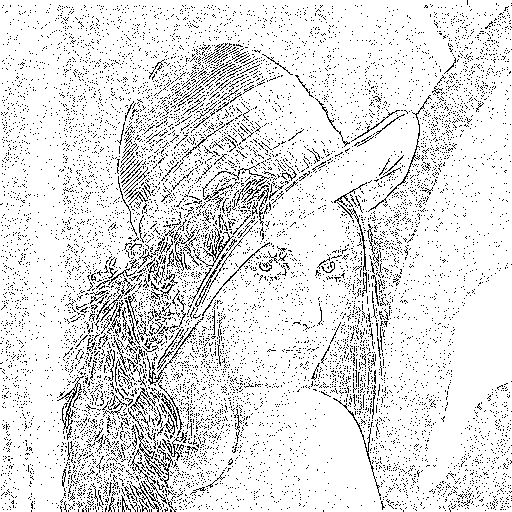

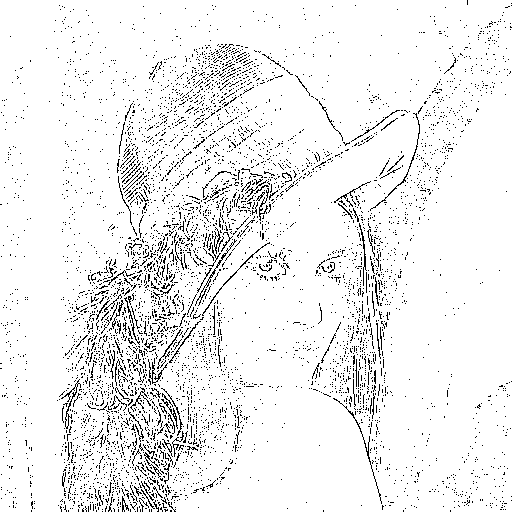

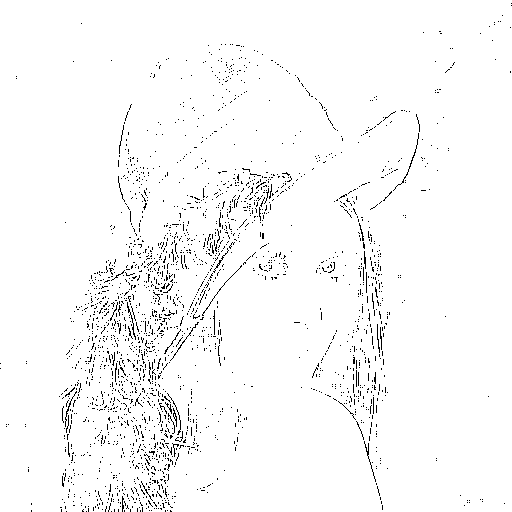

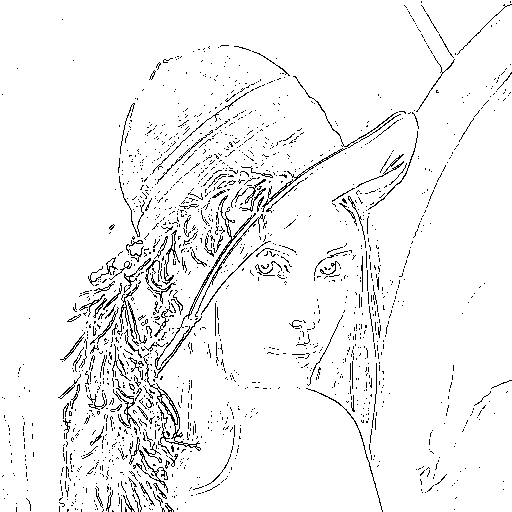

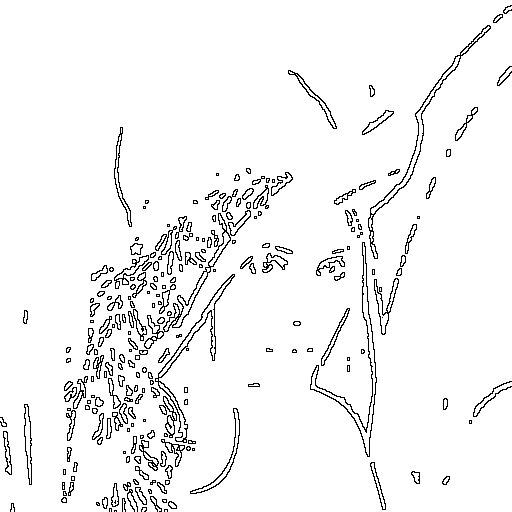

In [9]:
def Laplace_Mask1(img, threshold):
  border_img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE) 
  mask = np.array([[0,1,0],[1,-4,1],[0,1,0]])
  magnitude = conv(border_img, mask)
  return np.int8((magnitude > threshold))-np.int8((magnitude <= threshold*(-1)))

def Laplace_Mask2(img, threshold):
  border_img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE) 
  mask = np.array([[1,1,1],[1,-8,1],[1,1,1]])
  magnitude = conv(border_img, mask)/3
  return np.int8((magnitude > threshold))-np.int8((magnitude <= threshold*(-1)))

def Minimum_variance_Laplacian(img, threshold):
  border_img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_REPLICATE) 
  mask = np.array([[2,-1,2],[-1,-4,-1],[2,-1,2]])
  magnitude = conv(border_img, mask)/3
  return np.int8((magnitude > threshold))-np.int8((magnitude <= threshold*(-1)))

def Laplacian_of_Gaussian(img, threshold):
  border_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE) 
  mask = LoG_mtx
  magnitude = conv(border_img, mask)
  return np.int8((magnitude > threshold))-np.int8((magnitude <= threshold*(-1)))

def Difference_of_Gaussian(img, threshold):
  border_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE) 
  mask = DoG_mtx
  magnitude = conv(border_img, mask)
  return np.int8((magnitude > threshold))-np.int8((magnitude <= threshold*(-1)))

def zero_crossing(mtx):
  border_mtx = cv2.copyMakeBorder(mtx,1,1,1,1,cv2.BORDER_REPLICATE)
  M,N = mtx.shape
  cdt_part2 = np.zeros((M,N))
  for r in range(3):
    for c in range(3):
      cdt_part2 = np.minimum(border_mtx[r:r+M,c:c+N], cdt_part2)
  cdt = (mtx != 1)|(cdt_part2 != -1)
  return cdt*255

result = zero_crossing(Laplace_Mask1(lena_gray, 15))
cv2_imshow(result)
#cv2.imwrite("Laplace_Mask1_15.bmp", result)
result = zero_crossing(Laplace_Mask2(lena_gray, 15))
cv2_imshow(result)
#cv2.imwrite("Laplace_Mask2_15.bmp", result)
result = zero_crossing(Minimum_variance_Laplacian(lena_gray, 20))
cv2_imshow(result)
#cv2.imwrite("Minimum_variance_Laplacian_20.bmp", result)
result = zero_crossing(Laplacian_of_Gaussian(lena_gray, 3000))
cv2_imshow(result)
#cv2.imwrite("Laplacian_of_Gaussian_3000.bmp", result)
result = zero_crossing(Difference_of_Gaussian(lena_gray, 1))
cv2_imshow(result)
#cv2.imwrite("Difference_of_Gaussian_1.bmp", result)